<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/mlp/mlp_1d_regression_hetero_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1d Nonlinear heteroskedastic regression using an  MLP.

 Nonlinear regression using MLE with fixed variance or input-dependent variance.
We share the backbone and have two output heads for mu and sigma.
 When sigma is fixed, it is larger than necessary in some places,
 to compensate for growing noise in the input data.
 Code dapted from
 https://brendanhasz.github.io/2019/07/23/bayesian-density-net.html
and [here](https://colab.sandbox.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb#scrollTo=5zCEYpzu7bDX)

In [1]:

# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print("tf version {}".format(tf.__version__))
tf.config.list_physical_devices('GPU')

tf version 2.3.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow_probability as tfp
import scipy.stats
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

from IPython import display


sns.set(style="ticks", color_codes=True)

tfd = tfp.distributions

np.random.seed(12345)
tf.random.set_seed(12345)

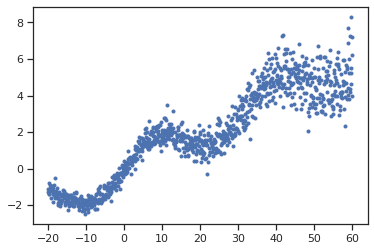

In [3]:


# Make data

x_range = [-20, 60]  # test
#x_ranges = [[-20, -10], [0, 20], [40, 50]]
#ns = [10, 10, 10]

#x_ranges = [ [-10,-5], [15,25], [35,50]]
#ns = [400, 400, 400]

x_ranges = [[-20, 60]]
ns = [1000]


def load_dataset():
    def s(x):  # std of noise
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return (0.25 + g**2.)
    x = []
    y = []
    for i in range(len(ns)):
        n = ns[i]
        xr = x_ranges[i]
        #x1 = (xr[1] - xr[0]) * np.random.rand(n) + xr[0]
        x1 = np.linspace(xr[0], xr[1], n)
        eps = np.random.randn(n) * s(x1)
        y1 = (1 * np.sin(0.2*x1) + 0.1 * x1) + eps
        x = np.concatenate((x, x1))
        y = np.concatenate((y, y1))
    # print(x.shape)
    x = x[..., np.newaxis]
    n_tst = 150
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst


y, x, x_tst = load_dataset()


plt.figure()
plt.plot(x, y, 'b.', label='observed')
#save_fig('nonlinreg_1d_hetero_data.pdf')
plt.show()


In [4]:
# Make model


class DenseNetwork(tf.keras.Model):
    """A multilayer fully-connected  neural network
    """

    def __init__(self, dims, name=None):
        super(DenseNetwork, self).__init__(name=name)
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            #self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            #tf.keras.layers.Dense(50, activation='relu', input_shape=(D,)),
            self.steps += [tf.keras.layers.Dense(dims[i+1])]
            self.acts += [tf.nn.relu]
        self.acts[-1] = lambda x: x

    def call(self, x):
        """Perform the forward pass"""
        for i in range(len(self.steps)):
            x = self.steps[i](x)
            x = self.acts[i](x)
        return x


def make_mlp(units):
    # Makes a stack of dense layers with Relu activations on hidden layers.
    # units=[2,10,1] has 2 inputs, 1 hidden layer with 10 units, and 1 linear output
    layers = []
    nlayers = len(units)
    for i in range(nlayers-2):
        layers += [tf.keras.layers.Dense(units[i+1],
                                         activation='relu', input_shape=(units[i],))]
    layers += [tf.keras.layers.Dense(units[nlayers-1], activation=None)]
    return tf.keras.Sequential(layers)

#mlp = make_mlp([2, 10, 20, 1])
# mlp.summmary()


class DensityNetwork(tf.keras.Model):
    """Multilayer fully-connected neural network, with
    two heads to predict both the mean and the standard deviation.
    Parameters
    ----------
    units : List[int]
        Number of output dimensions for each layer
        in the core network.
    head_units : List[int]
        Number of output dimensions for each layer
        in the head networks.
    fixed_variance: float or None if learned 
        If not None, then the output variance is a constant.
    name : None or str
        Name for the layer
    """

    def __init__(self, units, head_units, fixed_variance=None, name=None):

        # Initialize
        super(DensityNetwork, self).__init__(name=name)

        # Create sub-networks
        #self.core_net = DenseNetwork(units)
        #self.loc_net = DenseNetwork([units[-1]]+head_units)
        #self.std_net = DenseNetwork([units[-1]]+head_units)

        self.core_net = make_mlp(units)
        self.loc_net = make_mlp([units[-1]]+head_units)
        self.std_net = make_mlp([units[-1]]+head_units)
        self.fixed_variance = fixed_variance

    def call(self, x):
        """Pass data through the model
        Returns tfd.Normal() for 1d eventsize and x.shape[0] sample size
        """
        x = self.core_net(x)
        x = tf.nn.relu(x)
        # Make predictions with each head network
        loc_preds = self.loc_net(x)
        if self.fixed_variance is not None:
            std_preds = np.sqrt(self.fixed_variance).astype('float32')
        else:
            std_preds = 1e-3 + 0.05*self.std_net(x)
            std_preds = tf.nn.softplus(std_preds)
        # return tf.concat([loc_preds, std_preds], 1)
        # print(loc_preds.dtype)
        # print(std_preds.dtype)

        return tfd.Normal(loc=loc_preds, scale=std_preds)

# When we fit with fixed variance, minimizing NLL is equivalent
# to minimizing MSE. In this case, we compute the MLE of sigma^2 after training
# using the MSE the residuals.

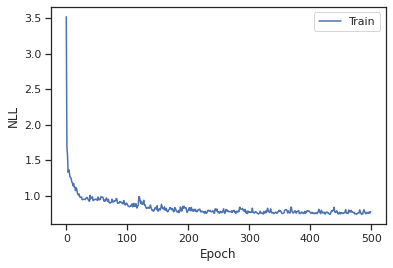

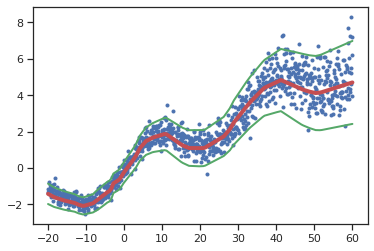


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



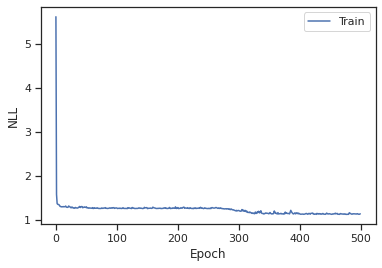

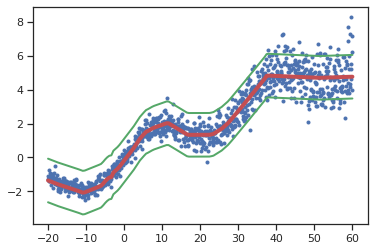

In [5]:
fixed_vars = [None,  1]

for fixed_var in fixed_vars:
    model = DensityNetwork([1, 50, 50], [20, 1], fixed_var)
    def negloglik(y, rv_y): return -rv_y.log_prob(y)
    model.compile(optimizer=tf.optimizers.Adam(
        learning_rate=0.01), loss=negloglik)
    history = model.fit(x, y, epochs=500, batch_size=100, verbose=False)
    if fixed_var is not None:
        # estimate MLE of sigma
        yhat_train = model(x)
        ypred = yhat_train.mean().numpy()[:, 0]
        # print(ypred.shape)
        residuals = (y-ypred)
        mse = np.mean((residuals ** 2))
        #mse = scipy.stats.trim_mean(residuals ** 2, proportiontocut=0.1)
        model.fixed_variance = mse
        # print(model.fixed_variance)
    yhat = model(x_tst)  # a Gaussian distribution object

    plt.plot(history.history['loss'], label='Train')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

    plt.figure()
    plt.plot(x, y, 'b.', label='observed')
    m = yhat.mean()
    s = yhat.stddev()
    plt.plot(x_tst, m, 'r', linewidth=4, label='mean')
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev')
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev')
    # plt.ylim([-10,10])
    plt.show()